In [1]:
import pandas as pd

file_path = "En SubjectLines.csv"
df = pd.read_csv(file_path)

print("Loaded rows:", len(df))
print("Columns:", df.columns.tolist())
df.head(3)

    

Loaded rows: 5889
Columns: ['subject', 'sendings', 'opens', 'open_rate']


,subject,sendings,opens,open_rate
0,Thank you{% if contact.1 == '{{ contact.1 }}' ...,64477108,17972995,0.278750
1,Your exclusive Photo Product offer awaits{% if...,43081180,12210189,0.283423
2,Your exclusive Photo Product offer awaits{% if...,41786220,11060178,0.264685


In [2]:
# keep only what we need
df = df[['subject', 'sendings', 'opens', 'open_rate']].copy()

# basic clean
df['subject'] = df['subject'].astype(str).str.strip()
df['sendings'] = pd.to_numeric(df['sendings'], errors='coerce')
df['opens'] = pd.to_numeric(df['opens'], errors='coerce')
df['open_rate'] = pd.to_numeric(df['open_rate'], errors='coerce')

# drop only truly broken rows
df = df.dropna(subset=['subject', 'sendings', 'opens'])
df = df[(df['sendings'] > 0) & (df['opens'] >= 0) & (df['opens'] <= df['sendings'])]

print("Rows after cleaning:", len(df))
df.head(3)


Rows after cleaning: 5889


,subject,sendings,opens,open_rate
0,Thank you{% if contact.1 == '{{ contact.1 }}' ...,64477108,17972995,0.278750
1,Your exclusive Photo Product offer awaits{% if...,43081180,12210189,0.283423
2,Your exclusive Photo Product offer awaits{% if...,41786220,11060178,0.264685


In [4]:
import re
import html
import unicodedata

def normalize_subject(subject: str) -> str:
    if not isinstance(subject, str):
        return ""

    subject = re.sub(r"\{\{.*?\}\}|\{%.*?%\}", " ", subject)
    subject = html.unescape(subject)
    subject = unicodedata.normalize("NFKC", subject)
    subject = subject.lower()
    subject = re.sub(r"\d+", " ", subject)          # remove ALL numbers
    subject = re.sub(r"[^\w\s]", " ", subject)      # remove punctuation
    subject = re.sub(r"_+", " ", subject)
    subject = re.sub(r"\s+", " ", subject).strip()

    return subject

df['subject_norm'] = df['subject'].apply(normalize_subject)

print("Unique subjects before:", df['subject'].nunique())
print("Unique subjects after normalization:", df['subject_norm'].nunique())

df[['subject', 'subject_norm']].head(5)


Unique subjects before: 5861
Unique subjects after normalization: 4416


,subject,subject_norm
0,Thank you{% if contact.1 == '{{ contact.1 }}' ...,thank you
1,Your exclusive Photo Product offer awaits{% if...,your exclusive photo product offer awaits
2,Your exclusive Photo Product offer awaits{% if...,your exclusive photo product offer awaits
3,Huge sale on Acrylic Prints – from £7.78!,huge sale on acrylic prints from
4,Sunday Savings! Canvases and Home Decorations ...,sunday savings canvases and home decorations from


Total rows (before any threshold): 5889

Sendings percentiles:
count    5.889000e+03
mean     1.239374e+06
std      2.833953e+06
min      1.000000e+00
1%       1.000000e+00
5%       3.000000e+00
10%      4.000000e+00
25%      8.000000e+00
50%      2.251450e+05
75%      1.196185e+06
90%      3.441658e+06
95%      6.146117e+06
99%      1.386952e+07
max      6.447711e+07
Name: sendings, dtype: float64

Rows kept if sendings >= threshold:
>=     50: 3906
>=    100: 3904
>=    200: 3904
>=    500: 3901
>=   1000: 3899
>=   5000: 3881
>=  10000: 3840
>= 100000: 3327


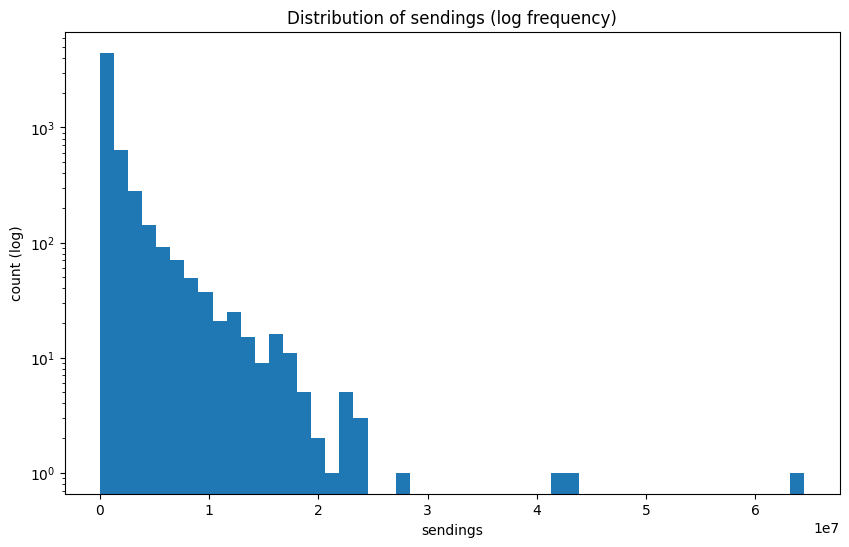

In [5]:
import matplotlib.pyplot as plt

print("Total rows (before any threshold):", len(df))

# Key percentiles of sendings
print("\nSendings percentiles:")
print(df['sendings'].describe(percentiles=[.01, .05, .10, .25, .50, .75, .90, .95, .99]))

# How many rows you keep at common thresholds
thresholds = [50, 100, 200, 500, 1000, 5000, 10000, 100000]
print("\nRows kept if sendings >= threshold:")
for t in thresholds:
    kept = (df['sendings'] >= t).sum()
    print(f">= {t:>6}: {kept}")

# Histogram (log scale helps with heavy tails)
plt.figure(figsize=(10,6))
plt.hist(df['sendings'], bins=50, log=True)
plt.title("Distribution of sendings (log frequency)")
plt.xlabel("sendings")
plt.ylabel("count (log)")
plt.show()


In [6]:
MIN_SENDINGS = 100

rows_before = len(df)
df = df[df['sendings'] >= MIN_SENDINGS].copy()
rows_after = len(df)

print("MIN_SENDINGS =", MIN_SENDINGS)
print("Rows before:", rows_before)
print("Rows after:", rows_after)
print("Removed:", rows_before - rows_after)

df['sendings'].describe()


MIN_SENDINGS = 100
Rows before: 5889
Rows after: 3904
Removed: 1985


count    3.904000e+03
mean     1.869535e+06
std      3.307184e+06
min      2.900000e+02
25%      2.294010e+05
50%      6.466130e+05
75%      2.028571e+06
max      6.447711e+07
Name: sendings, dtype: float64

In [7]:
# Sort so the representative subject is the one with the highest sendings
df_sorted = df.sort_values(['subject_norm', 'sendings'], ascending=[True, False])

# Aggregate
df_joined = (
    df_sorted
    .groupby('subject_norm', as_index=False)
    .agg(
        subject=('subject', 'first'),          # representative subject
        total_sendings=('sendings', 'sum'),
        total_opens=('opens', 'sum')
    )
)

# Recompute open rate from totals (single source of truth)
df_joined['open_rate'] = df_joined['total_opens'] / df_joined['total_sendings']

print("Rows before aggregation:", len(df))
print("Rows after aggregation:", len(df_joined))
print("Merged rows:", len(df) - len(df_joined))

df_joined.head(5)


Rows before aggregation: 3904
Rows after aggregation: 2780
Merged rows: 1124


,subject_norm,subject,total_sendings,total_opens,open_rate
0,a a a a gift from our ceo free shipping just f...,{% if contact.1 == '' %}{% if contact.1 == tru...,2117723,778373,0.367552
1,a big thank you from us to you save up to today,A Big Thank You from Us to You – Save up to 92...,241030,58863,0.244214
2,a big thank you with an exclusive treat,A big Thank You with an exclusive treat,959723,328263,0.342039
3,a christmas in july mystery discount ready rea...,&#x1f385; A Christmas in July Mystery discount...,14225921,4108085,0.288775
4,a few hours left get up to off,&#x23f3; A few hours left! Get up to 93% off!,72795,18090,0.248506


In [8]:
import numpy as np

def wilson_lower_bound(opens: int, sendings: int, z: float = 1.96) -> float:
    """
    95% Wilson score lower bound.
    Use this to rank email subjects with different volumes.
    """
    if sendings <= 0:
        return 0.0

    p = opens / sendings
    z2 = z * z
    denom = 1 + z2 / sendings
    center = p + z2 / (2 * sendings)
    margin = z * np.sqrt((p * (1 - p) + z2 / (4 * sendings)) / sendings)

    return (center - margin) / denom


# Safety clamp (just in case)
df_joined['total_opens'] = df_joined['total_opens'].clip(
    lower=0, upper=df_joined['total_sendings']
)

# Compute Wilson score
df_joined['wilson_score'] = df_joined.apply(
    lambda r: wilson_lower_bound(r['total_opens'], r['total_sendings']),
    axis=1
)

# Sort by Wilson score
df_ranked = df_joined.sort_values('wilson_score', ascending=False)

df_ranked.head(10)


,subject_norm,subject,total_sendings,total_opens,open_rate,wilson_score
960,herzlichen glückwunsch glückwunsch glückwunsch...,Herzlichen{% if contact.1 == '{{ contact.1 }} ...,542,432,0.797048,0.761151
974,highly discounted canvas premium prints,Highly discounted Canvas & Premium Prints,523843,352196,0.672331,0.671059
1497,most popular formats highly reduced,Most popular formats highly reduced!,501382,336477,0.671099,0.669797
1478,mega sale gigantic canvases for each,Mega Sale: Gigantic Canvases for £22 each,527528,353574,0.670247,0.668977
1580,off giant canvas print,80% off giant Canvas Print!,529078,353562,0.668261,0.666991
117,big canvas print premium frame,Big Canvas Print £20 + Premium Frame £15,503435,335341,0.666106,0.664802
1422,lowest prices on our most popular products,Lowest prices on our most popular products,577097,383072,0.663791,0.662571
351,days up to on canvases,2 days: Up to -75% on 3 Canvases!,542587,356864,0.657708,0.656445
2575,xxl canvas for only,XXL Canvas for only £22,84208,55539,0.659545,0.656338
1013,hours xxl canvas only,(48 hours) XXL Canvas only £22,555123,364124,0.655934,0.654683


In [9]:
# Select final columns
final_cols = [
    'subject',
    'total_sendings',
    'total_opens',
    'open_rate',
    'wilson_score'
]

final_table = df_ranked[final_cols].copy()

# Top 30 subjects
top_30 = final_table.head(30)
top_30



,subject,total_sendings,total_opens,open_rate,wilson_score
960,Herzlichen{% if contact.1 == '{{ contact.1 }} ...,542,432,0.797048,0.761151
974,Highly discounted Canvas & Premium Prints,523843,352196,0.672331,0.671059
1497,Most popular formats highly reduced!,501382,336477,0.671099,0.669797
1478,Mega Sale: Gigantic Canvases for £22 each,527528,353574,0.670247,0.668977
1580,80% off giant Canvas Print!,529078,353562,0.668261,0.666991
117,Big Canvas Print £20 + Premium Frame £15,503435,335341,0.666106,0.664802
1422,Lowest prices on our most popular products,577097,383072,0.663791,0.662571
351,2 days: Up to -75% on 3 Canvases!,542587,356864,0.657708,0.656445
2575,XXL Canvas for only £22,84208,55539,0.659545,0.656338
1013,(48 hours) XXL Canvas only £22,555123,364124,0.655934,0.654683


In [10]:
top_30.to_csv("top_email_subjects_wilson.csv", index=False)
print("Saved: top_email_subjects_wilson.csv")


Saved: top_email_subjects_wilson.csv
